In [26]:
from collections import Counter
from typing import List, Tuple
from music21.harmony import ChordSymbol
from torch.utils.data import random_split, Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import glob
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import time

In [34]:
# Initialize constants

batch_size = 1024
max_len = 8 # Max chords in a sequence
num_layers = 4 # Number of encoder layers
d_model = 128 # Embedding dimension, think 3Blue1Brown
input_dim = 13 # 12 chroma + 1 time
n_heads = 4 # Number of attention heads for transformer
num_classes = 12 # 12 chroma

max_duration = 64.0

note_to_int = {"C": 0, "C#": 1, "D-": 1, "D": 2, "D#": 3, "E-": 3, "E": 4, "F": 5, "F#": 6, "G-": 6, "G": 7, "G#": 8, "A-": 8, "A": 9, "A#": 10, "B-": 10, "B": 11}

from pathlib import Path
PROJECT_ROOT = Path(os.getcwd()).parent
features_base = PROJECT_ROOT / 'data' / 'features'
labels_base = PROJECT_ROOT / 'data' / 'labels'
models_base = PROJECT_ROOT / 'models'

In [28]:
# Function definitions

def parse_raw_chord(raw_chord: str) -> Tuple[ChordSymbol, ChordSymbol]:
    chord = None
    bass = None
    if '/' in raw_chord:
        top, bottom = raw_chord.split('/')
        return (ChordSymbol(top), ChordSymbol(bottom))
    else:
        return (ChordSymbol(raw_chord), None)


def as_basic_midi(chord: ChordSymbol, bass: ChordSymbol) -> List[int]:
    midi = chord.orderedPitchClasses
    if bass:
        midi.extend(bass.orderedPitchClasses)

    return [1 if i in list(set(midi)) else 0 for i in range(12)]


def permute_to_midi(chord: ChordSymbol, bass: ChordSymbol) -> List[int]:
    octave = np.random.randint(3, 6)

    # Place the notes of the chord at random starting at `octave`
    midi = []
    upper_octave = octave

    for note in np.random.permutation(chord.pitchClasses):
        # Pick the next pitch above the last note in the MIDI
        pitch = note + upper_octave * 12
        if len(midi) > 0 and pitch < midi[-1]:
            upper_octave += 1
            pitch = note + upper_octave * 12

        midi.append(pitch)

    if bass:
        # For the bass, place the root and then optionally the fifth and/or the octave
        offset = octave - 1 + np.random.randint(-2, 1)
        pitch = bass.root().pitchClass + offset * 12
        if pitch < midi[0]:
            octave -= 1
            pitch = bass.root().pitchClass + octave * 12

        midi.append(pitch)
        if np.random.rand() < 0.5 and pitch + 7 < midi[0]:
            midi.append(pitch + 7)
        if np.random.rand() < 0.5 and pitch + 12 < midi[0]:
            midi.append(pitch + 12)

    return midi


def load_file(file_path: str) -> List[str]:
    with open(file_path, "r") as f:
        return f.readlines()


def parse_bars(lines: List[str]) -> list:
    beats_per_measure = get_beats_per_measure(lines)
    bars = []
    for line in lines[3:]:
        if line.strip() == "":
            continue

        beats = line.strip().split(' ')
        if len(beats) == 1:
            for i in range(beats_per_measure):
                bars.append(beats[0])
        elif len(beats) == 2:
            for i in range(beats_per_measure // 2):
                bars.append(beats[0])
            for i in range(beats_per_measure // 2):
                bars.append(beats[1])
        elif len(beats) != 0:
            i = 0
            while i < len(beats):
                element = beats[i]
                if element.startswith("["):
                    beat = [element[1:]]
                    i += 1
                    while not beats[i].endswith("]"):
                        beat.append(beats[i])
                        i += 1
                    beat.append(beats[i][:-1])
                else:
                    beat = element

                bars.append(beat)
                i += 1

    return bars


def get_beats_per_measure(lines: List[str]) -> int:
    return int(lines[1].split(' ')[2].split('/')[0])


def extract_durations(bars: list, rhythm_variance: float, beats_per_measure: int) -> pd.DataFrame:
    assert(rhythm_variance <= 1 and rhythm_variance >= 0)

    compressed_bars = []
    durations = []

    curr_chord = ""
    num_beats = 0
    for bar in bars:
        if type(bar) is list:
            for symbol in bar:
                if symbol != curr_chord and curr_chord != "":
                    compressed_bars.append(curr_chord)
                    durations.append(num_beats)
                    num_beats = 1 / len(bar)
                else:
                    num_beats += 1 / len(bar)
                curr_chord = symbol
        else:
            if bar != curr_chord and curr_chord != "":
                compressed_bars.append(curr_chord)
                durations.append(num_beats)
                num_beats = 1
            else:
                num_beats += 1
            curr_chord = bar

    return pd.DataFrame({"Chord": compressed_bars, "Duration": durations})


def create_progressions(song: pd.DataFrame) -> pd.DataFrame:
    rows = []
    progression_num = 0

    # Generate all contiguous subarrays
    for start in range(len(song)):
        for end in range(start + 1, len(song) + 1):
            sub_df = song.iloc[start:end]
            for i, row in enumerate(sub_df.itertuples(index=False)):
                rows.append({
                    "Progression Number": progression_num,
                    "Chord Index in Progression": i,
                    "Chord": row.Chord,
                    "MIDI": row.MIDI,
                    "Duration": row.Duration,
                    "Label": row.Label,
                    "features": row.features,
                })
            progression_num += 1

    return pd.DataFrame(rows)


def sliding_window_dataframe(df, max_len=16):
    new_rows = []
    next_prog_num = df["Progression Number"].max() + 1

    for prog_num, group in df.groupby("Progression Number"):
        # ensure order is correct
        group = group.sort_values("Chord Index in Progression").reset_index(drop=True)
        seq_len = len(group)

        if seq_len <= max_len:
            # keep as-is
            new_rows.append(group)
        else:
            # sliding windows
            for start in range(0, seq_len - max_len + 1):
                window = group.iloc[start:start + max_len].copy()
                window["Progression Number"] = next_prog_num
                new_rows.append(window)
                next_prog_num += 1

    # combine everything
    new_df = pd.concat(new_rows, ignore_index=True)
    return new_df

In [5]:
# Custom dataset

class SongDataset(Dataset):
    def __init__(self, feature_files, label_files, pad_token_id=-100, mmap=True):
        self.feature_files = feature_files
        self.label_files = label_files
        self.pad_token_id = pad_token_id
        self.mmap = mmap
        self.index_map = []

        self.song_lengths = [len(np.load(f, mmap_mode="r")) for f in self.label_files]

    def __len__(self):
        return sum(self.song_lengths)

    def __getitem__(self, idx):
        # Find which song this index belongs to
        for song_idx, song_len in enumerate(self.song_lengths):
            if idx < song_len:
                # Load the actual data for this song
                x = np.load(self.feature_files[song_idx], mmap_mode="r" if self.mmap else None)
                y = np.load(self.label_files[song_idx], mmap_mode="r" if self.mmap else None)

                # Extract the frame
                x_item = x[idx]
                y_item = y[idx]

                # Build mask
                mask_item = (y_item != self.pad_token_id).astype(np.int64)

                return (
                    torch.from_numpy(x_item),
                    torch.from_numpy(y_item),
                    torch.from_numpy(mask_item)
                )

            # Decrement idx to move into the next song’s range
            idx -= song_len

        raise IndexError("Index out of range in SongDataset")


# def collate_fn(batch):
#     feats, labels, masks = zip(*batch)

#     # feats is a tuple of [seq_len, 16, 13] tensors
#     # First flatten time dims if needed, or just pad
#     feats_padded = pad_sequence(feats, batch_first=True, padding_value=-1)
#     labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)  # ignore_index for CrossEntropy
#     masks_padded = pad_sequence(masks, batch_first=True, padding_value=-1)

#     return feats_padded, labels_padded, masks_padded

In [6]:
# Create embedding for midi + duration

class ChordEmbedding(nn.Module):
    def __init__(self, input_dim=input_dim, d_model=d_model):
        super().__init__()

        self.proj = nn.Linear(input_dim, d_model)

    def forward(self, x):
        # x: (batch, seq_len, num_features)
        return self.proj(x)  # (batch, seq_len, d_model)


# Create positional encoding for chords
class PositionalEncoding(nn.Module):

    def __init__(self, d_model=d_model, max_len=max_len):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0)]

In [7]:
class ChordTransformer(nn.Module):

    def __init__(self, d_model=128, n_heads=8, num_layers=8, input_dim=13, num_classes=12):
        super().__init__()

        # Map chord features to transformer dimension
        self.embedding = nn.Linear(input_dim, d_model)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Final linear layer to map hidden states to chord root probabilities
        self.fc_out = nn.Linear(d_model, num_classes)

    def forward(self, x, src_key_padding_mask=None):
        """
        x: (seq_len, batch_size, d_model)
        src_key_padding_mask: (batch_size, seq_len), True=padding positions
        """
        x = self.embedding(x)  # (batch_size, seq_len, d_model)
        x = x.transpose(0, 1)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        out = self.fc_out(x)  # (seq_len, batch_size, num_classes)
        return out

In [8]:
# 4) Create attention mask (1 = real data, 0 = padding)
feature_files = glob.glob(str(features_base / "*.npy"))
label_files = glob.glob(str(labels_base / "*.npy"))

X_train, X_test, y_train, y_test = train_test_split(feature_files, label_files, test_size=0.2, random_state=41)

train_dataset = SongDataset(X_train, y_train)
test_dataset  = SongDataset(X_test, y_test)

In [9]:
model = ChordTransformer(d_model=d_model, n_heads=n_heads, num_layers=num_layers, input_dim=input_dim, num_classes=num_classes)
model.load_state_dict(torch.load(str(models_base / "model31.pth")))
model.eval()

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min',
                                                       factor=0.5,
                                                       patience=5)



/Users/jameshollingsworth/Projects/ear-trainer/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/var/folders/gy/m0z5x2cs3453xqg1kjfyt7xc0000gn/T/ipykernel_62455/2030940080.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly

In [47]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
batches = []
num_batches = int(len(train_dataloader))
print(f"# of batches: {num_batches}")
for i, batch in enumerate(train_dataloader):
    if i >= num_batches:
        break
    batches.append(batch)

# of batches: 216646


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used.")
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU.")

model.to(device)

num_epochs = 100
best_loss = float('inf')

for epoch in range(num_epochs):
    start = time.time()

    total_tokens = 0
    epoch_loss = 0.0

    i = 0
    for feats, labels, mask in batches:
        # feats: (B, max_len, 13)
        # labels: (B, max_len)
        # mask: (B, max_len)

        feats = feats.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        mask = mask.to(device, non_blocking=True)

        optimizer.zero_grad()

        src_key_padding_mask = (mask == 0).to(device, non_blocking=True)
        logits = model(feats, src_key_padding_mask=src_key_padding_mask)

        batch_size, seq_len, num_classes = logits.shape

        loss = criterion(
            logits.reshape(batch_size * seq_len, num_classes),  # (N, C)
            labels.reshape(batch_size * seq_len)               # (N)
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        num_tokens = (mask != -1).sum().item()
        epoch_loss += loss.item() * num_tokens
        total_tokens += num_tokens

        i += 1

    avg_loss = epoch_loss / total_tokens
    scheduler.step(avg_loss)

    if epoch % 10:
        print(f"Loss: {avg_loss}  Time: {time.time() - start}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), str(models_base / f"model{epoch}.pth"))

GPU not available, using CPU.
Loss: 2.3723313812424975  Time: 3893.889967918396
Loss: 2.3720132982869995  Time: 3872.798441886902
Loss: 2.3717974053254003  Time: 3898.812266111374
Loss: 2.371686688236884  Time: 3856.927789211273
Loss: 2.3716431893894323  Time: 3923.157041311264
Loss: 2.3715326266511267  Time: 3987.365783214569
Loss: 2.3715125888117714  Time: 3721.5019431114197
Loss: 2.371399066120983  Time: 3861.0013461112976
Loss: 2.3714615790992437  Time: 3800.098909139633
Loss: 2.371476291550111  Time: 3785.5728719234467
Loss: 2.3713735486590313  Time: 3826.592761993408
Loss: 2.371407255158216  Time: 3822.2999217510223
Loss: 2.3713570792033685  Time: 3812.5396349430084
Loss: 2.37065680205933  Time: 3849.3687028884888
Loss: 2.3705758065208333  Time: 3903.2802941799164
Loss: 2.3706039051819077  Time: 3871.4008181095123
Loss: 2.370594351017813  Time: 3790.699704170227
Loss: 2.3706110007630445  Time: 3725.8478050231934
Loss: 2.37062548234642  Time: 4168.964622735977
Loss: 2.370340776844

KeyboardInterrupt: 

In [21]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()  # set model to evaluation mode
total_loss = 0.0
total_correct = 0
total_tokens = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for feats, labels, mask in test_dataloader:
        # src_key_padding_mask: True for padding positions
        src_key_padding_mask = (mask == -1)

        logits = model(feats, src_key_padding_mask=src_key_padding_mask)
        batch_size, seq_len, num_classes = logits.shape

        # Compute loss
        loss = criterion(
            logits.reshape(batch_size * seq_len, num_classes),
            labels.reshape(batch_size * seq_len)
        )
        total_loss += loss.item()

        # Compute accuracy ignoring padding
        predictions = logits.argmax(dim=-1)  # (batch_size, seq_len)
        predictions = predictions.transpose(0, 1)
        mask_bool = mask.bool()
        correct = (predictions == labels) & mask_bool
        total_correct += correct.sum().item()
        total_tokens += mask_bool.sum().item()

        all_predictions.extend(predictions.flatten().tolist())
        all_labels.extend(labels.flatten().tolist())

# Average loss
avg_loss = total_loss / len(test_dataloader)

# Accuracy ignoring padded tokens
accuracy = total_correct / total_tokens

print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

Test Loss: 1.6638, Test Accuracy: 0.9974


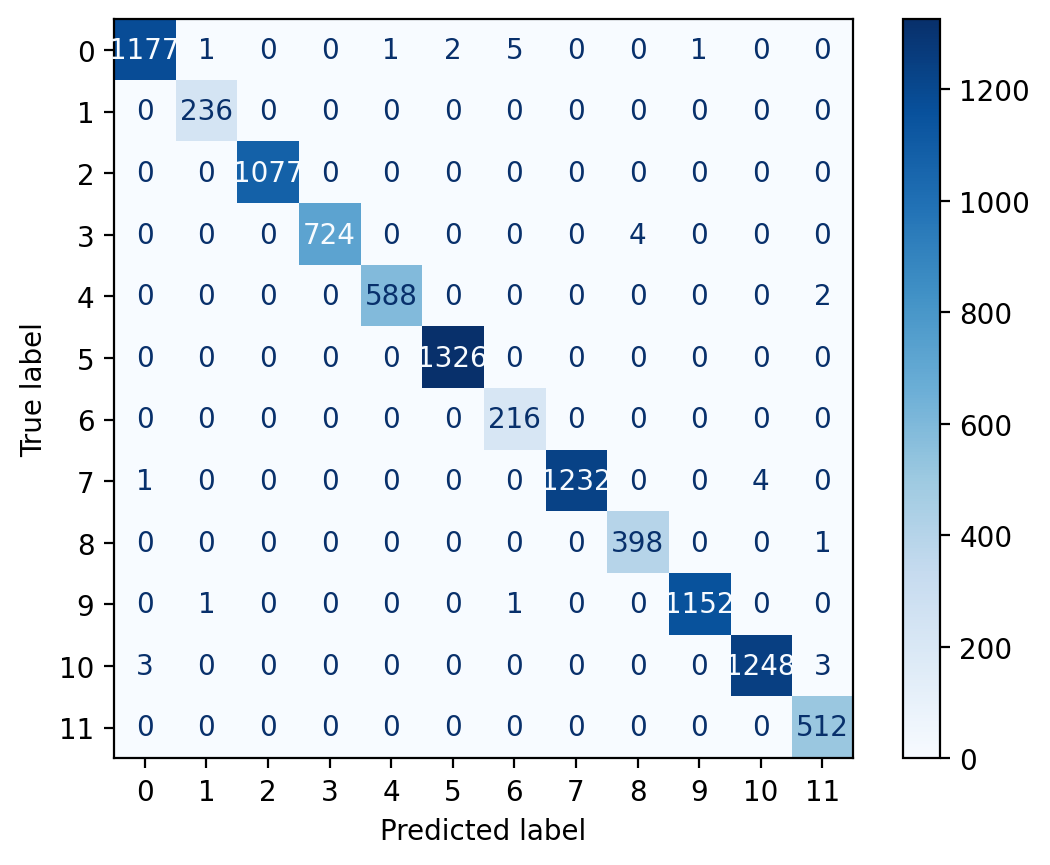

In [24]:
indices = np.random.choice(len(all_labels), size=10000)

labels_sample = [all_labels[i] for i in indices]
predictions_sample = [all_predictions[i] for i in indices]

cm = confusion_matrix(labels_sample, predictions_sample)
cm_filtered = cm[1:, 1:]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_filtered)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [36]:
###############################################
# ----THIS CODE ONLY NEEDS TO BE RUN ONCE---- #
###############################################


# Precompute the inputs for each song (permutations and yada yada)

files = os.listdir(str(PROJECT_ROOT / 'data' / 'chords' / 'Jazz'))

done = [f.name for f in features_base.glob("*.npy")]

i = 0
for f in files:
    name = f[:-4]
    if name + ".npy" in done:
        continue

    path = str(PROJECT_ROOT / 'data' / 'chords' / 'Jazz' / f)
    lines = load_file(path)
    bars = parse_bars(lines)
    chords_and_durations = extract_durations(bars, 0.15, get_beats_per_measure(lines))

    # Scale duration values
    chords_and_durations['Duration'] = chords_and_durations['Duration'] * (1 / max_duration)

    # Right now this doesn't change the chord voicings because we're using the basic MIDI representation
    chords_and_durations['MIDI'] = chords_and_durations['Chord'].apply(parse_raw_chord)
    chords_and_durations['MIDI'] = chords_and_durations['MIDI'].apply(lambda x: as_basic_midi(x[0], x[1]))

    # Create the features column
    chords_and_durations["features"] = [
        (list(m) if isinstance(m, (list, np.ndarray)) else [m]) + [d]
        for m, d in zip(chords_and_durations["MIDI"], chords_and_durations["Duration"])
    ]

    # Create labels
    chords_and_durations['Label'] = chords_and_durations['Chord'].apply(lambda x: x[0:2] if len(x) > 1 and (x[1] == "-" or x[1] == "#") else x[0])
    chords_and_durations['Label'] = chords_and_durations['Label'].apply(lambda x: note_to_int[x])

    all_progressions = create_progressions(chords_and_durations)

    # Do the sliding window thing to remove all sequences greater than the max_len
    all_progressions = sliding_window_dataframe(all_progressions, max_len)

    max_num = np.max(all_progressions['Progression Number'])
    split_progressions = all_progressions.groupby("Progression Number")
    inputs = split_progressions["features"].apply(lambda x: [torch.tensor(y) for y in x]).tolist()
    labels = split_progressions["Label"].apply(lambda x: torch.tensor(list(x))).tolist()

    # 1) Stack feature sequences into tensors (seq_len, feature_dim)
    input_seqs = [torch.stack(seq) for seq in inputs]

    # 2) Pad features with -1
    inputs_padded = pad_sequence(input_seqs, batch_first=True, padding_value=-1)

    # 3) Pad labels with -100 (default ignore_index for CrossEntropyLoss)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)

    target_length = max_len
    current_length = inputs_padded.size(1)

    if current_length < target_length:
        padding_needed = target_length - current_length
        # Pad along the sequence dimension (dim=1)
        inputs_padded = F.pad(inputs_padded, (0, 0, 0, padding_needed), 'constant', -1)
        labels_padded = F.pad(labels_padded, (0, padding_needed), 'constant', -100)

    np.save(str(features_base / name), inputs_padded.numpy())
    np.save(str(labels_base / name), labels_padded.numpy())

    print(f"{name} done, {i + 1}/{len(files)}")
    i += 1

Giant Steps_1 done, 1/148
Fly Me To The Moon_1 done, 2/148
Blue Moon_1 done, 3/148
Confirmation_1 done, 4/148
Cold Duck Time_1 done, 5/148
On Green Dolphin Street_1 done, 6/148
How Insensitive_1 done, 7/148
Autumn Leaves_1 done, 8/148
My Romance_1 done, 9/148
Indiana_1 done, 10/148
Jazz Impressions_1 done, 11/148
Groovin' High_1 done, 12/148
Bye Bye Blackbird_1 done, 13/148
Black Orpheus (A Day in the Life of a Fool)_1 done, 14/148
C-Jam Blues_1 done, 15/148
Equinox_1 done, 16/148
Mr. P.C_1 done, 17/148
Invitation_1 done, 18/148
Lover Man_1 done, 19/148
Anthropology_1 done, 20/148
Now's The Time_1 done, 21/148
Gone With The Wind_1 done, 22/148
I Remember You_1 done, 23/148
Cool Blues_1 done, 24/148
Minority_1 done, 25/148
Have You Met Miss Jones_1 done, 26/148
Ceora_1 done, 27/148
Caravan_1 done, 28/148
Bag's Groove_1 done, 29/148
But Not For Me_1 done, 30/148
Lullaby Of Birdland_1 done, 31/148
I've Never Been In Love Before_1 done, 32/148
I Fall In Love Too Easily_1 done, 33/148
Panno

In [33]:
files = os.listdir(str(PROJECT_ROOT / 'data' / 'chords' / 'Jazz'))

# Calculate highest overall duration
max_duration = float("-inf")

for f in files:
    path = str(PROJECT_ROOT / 'data' / 'chords' / 'Jazz' / f)
    lines = load_file(path)
    bars = parse_bars(lines)
    chords_and_durations = extract_durations(bars, 0.15, get_beats_per_measure(lines))

    # Scale duration values
    max_duration = max(max_duration, np.max(chords_and_durations['Duration']))
    print(f"Max duration: {max_duration} for {f}")

print(max_duration)

Max duration: 4 for Giant Steps_1.txt
Max duration: 4 for Fly Me To The Moon_1.txt
Max duration: 8 for Blue Moon_1.txt
Max duration: 8 for Confirmation_1.txt
Max duration: 8 for Cold Duck Time_1.txt
Max duration: 8 for On Green Dolphin Street_1.txt
Max duration: 8 for How Insensitive_1.txt
Max duration: 8 for Autumn Leaves_1.txt
Max duration: 8 for My Romance_1.txt
Max duration: 8 for Indiana_1.txt
Max duration: 64 for Jazz Impressions_1.txt
Max duration: 64 for Groovin' High_1.txt
Max duration: 64 for Bye Bye Blackbird_1.txt
Max duration: 64 for Black Orpheus (A Day in the Life of a Fool)_1.txt
Max duration: 64 for C-Jam Blues_1.txt
Max duration: 64 for Equinox_1.txt
Max duration: 64 for Mr. P.C_1.txt
Max duration: 64 for Invitation_1.txt
Max duration: 64 for Lover Man_1.txt
Max duration: 64 for Anthropology_1.txt
Max duration: 64 for Now's The Time_1.txt
Max duration: 64 for Gone With The Wind_1.txt
Max duration: 64 for I Remember You_1.txt
Max duration: 64 for Cool Blues_1.txt
Max d